# Offset Ground-truthing

## In MintPy environment

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from pathlib import Path
from datetime import datetime

from mintpy.objects import timeseries
from mintpy.utils import readfile
from mintpy import view

steps:

change date to years from start
run linear regression (without intercept) for E and N displacement
get average peg location, associate with regression info and create quiver plot

get timeseries location that matches pegs
change date to years from start
run linear regression (without intercept) for E and N displacement
associate location info with regression info
add to quiver plot

In [2]:
pwd

'/home/micromamba/pixel/pixeloffset_mintpy'

In [3]:
def linear(x,a):
    return a*x

In [31]:
pegs = pd.read_csv('peg_data/pegs.csv')
pegs.columns = map(str.lower, pegs.columns)
pegs['date'] = pd.to_datetime(pegs.date.astype(str))

In [32]:
# data_wd = Path('/home/micromamba/pixel/poroa/autorift/mintpy')
# tsobj_ns = timeseries(data_wd / 'timeseriesAz.h5')
# tsobj_ew = timeseries(data_wd / 'timeseriesRg.h5')

# atr = tsobj_ns.get_metadata()
# dates = pd.to_datetime(tsobj_ns.get_date_list())
# dates = pd.Series(dates)
# years = (dates - dates.min()).dt.days / 365.25

data_wd = Path('/home/micromamba/pixel/poroa/autorift_16_32_sr10/mintpy')
vel_ns, atr = readfile.read(data_wd / 'velocityAz.h5')
vel_ew, _ = readfile.read(data_wd / 'velocityRg.h5')

In [33]:
x_first, y_first, x_step, y_step = [float(x) for x in [atr['X_FIRST'], atr['Y_FIRST'], atr['X_STEP'], atr['Y_STEP']]]

In [34]:
cols = ['name', 'east', 'north','n_rate', 'e_rate', 'row', 'column','pt_n_rate','pt_e_rate']
peg_rate = pd.DataFrame(columns=cols)

peg_rate[cols[0:3]] = pegs[cols[0:3]].groupby('name').mean().reset_index()
# peg_rate[cols[0:3]] = pegs.loc[pegs['cum_e_disp'] == 0, cols[0:3]]

peg_rate = peg_rate.reset_index(drop=True)

In [35]:
for i, row in peg_rate.iterrows():
    
    # Grab data
    peg_name = row['name']
    df = pegs.loc[pegs.name == peg_name].copy()
    
    # Get yearly peg displacement rate
    df['years'] = (df.date - df.date.min()).dt.days / 365.25
    n_rate, _ = curve_fit(linear,df['years'],df['cum_n_disp'])
    e_rate, _ = curve_fit(linear,df['years'],df['cum_e_disp'])
    row['n_rate'] = float(n_rate)
    row['e_rate'] = float(e_rate)
    
    # Get peg location in MintPy data
    dX = row['east'] - x_first
    row['column'] = int(np.floor(dX / x_step))
    dY = row['north'] - y_first
    row['row'] = int(np.floor(dY / y_step))
    
    # # Get yearly mintpy displacement rate from timeseries
    # box = (row['column']-1,row['row']-1,row['column'],row['row'])
    # pt_n_rate, _ = curve_fit(linear,years,tsobj_ns.read(box=box))#.mean(axis=(1,2)))
    # pt_e_rate, _ = curve_fit(linear,years,tsobj_ew.read(box=box))#.mean(axis=(1,2)))
    
    # Get yearly mintpy displacement rate from velocity
    icol, irow = int(row['column']), int(row['row'])
    pt_n_rate = vel_ns[irow-1:irow,icol-1:icol]
    pt_e_rate = vel_ew[irow-1:irow,icol-1:icol]

    row['pt_n_rate'] = float(pt_n_rate)
    row['pt_e_rate'] = float(pt_e_rate)
    
    # Set data in dataframe
    peg_rate.iloc[i] = row

In [36]:
cols = list(peg_rate.columns)
cols.remove('name')
peg_rate[cols] = peg_rate[cols].astype(float)

[(400993.1618008809, 402686.36531592475),
 (5598148.980075604, 5600490.808199079)]

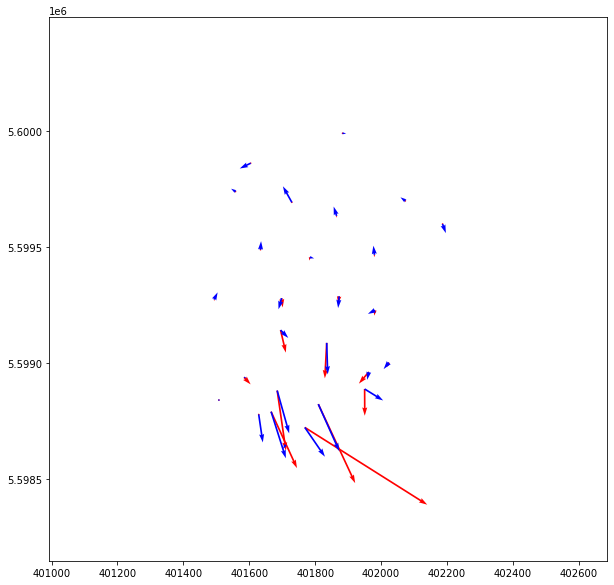

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

b = 500

bounds = [peg_rate.east.min()-b,peg_rate.east.max()+b,peg_rate.north.min()-b,peg_rate.north.max()+b]

fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(peg_rate.east, peg_rate.north, peg_rate.e_rate, peg_rate.n_rate,scale=50,color='red',width=0.003)
ax.quiver(peg_rate.east, peg_rate.north, peg_rate.pt_e_rate, peg_rate.pt_n_rate,scale=50,color='blue',width=0.003)
ax.set(xlim=(bounds[0],bounds[1]),ylim=(bounds[2],bounds[3]))

# for i, row in peg_rate.iterrows():
#     ax.annotate(row['name'], (row['east'], row['north']))

## RMSE

In [38]:
peg_rate['e_resid_sq'] = (peg_rate.e_rate - peg_rate.pt_e_rate)**2
peg_rate['n_resid_sq'] = (peg_rate.n_rate - peg_rate.pt_n_rate)**2

In [19]:
og = peg_rate.copy()

In [19]:
# peg_rate = og.copy()

In [20]:
peg_rate = peg_rate.loc[peg_rate.name != 'Peg 22']

In [39]:
peg_rate.sort_values('n_resid_sq',ascending=False)

,name,east,north,n_rate,e_rate,row,column,pt_n_rate,pt_e_rate,e_resid_sq,n_resid_sq
13,Peg 22,401768.407923,5.598724e+06,-6.922811,10.970572,65.0,57.0,-2.624499,1.803510,84.035019,18.475485
12,Peg 21,401809.341303,5.598824e+06,-7.077138,3.303934,62.0,58.0,-4.222097,1.886160,2.010085,8.151259
17,Peg 26,401628.545392,5.598779e+06,-0.022071,-0.055180,63.0,54.0,-2.510342,0.368606,0.179594,6.191496
15,Peg 24,401684.562912,5.598882e+06,-5.381426,0.782261,61.0,55.0,-3.837068,1.075844,0.086191,2.385041
21,Peg 4,401729.048366,5.599693e+06,-0.098124,-0.023010,41.0,56.0,1.436999,-0.797952,0.600535,2.356602
11,Peg 20,401949.931298,5.598889e+06,-2.397213,0.011741,61.0,62.0,-1.028043,1.661326,2.721129,1.874626
5,Peg 14,401694.803907,5.599143e+06,-2.017309,0.475897,54.0,55.0,-0.698278,0.693308,0.047268,1.739843
25,Peg 8,401979.715525,5.599467e+06,-0.210464,-0.029333,46.0,63.0,0.818635,-0.095169,0.004334,1.059045
22,Peg 5,401864.928367,5.599635e+06,-0.164893,-0.024400,42.0,60.0,0.836940,-0.266176,0.058456,1.003669
16,Peg 25,401666.119835,5.598791e+06,-5.059485,2.319237,63.0,55.0,-4.176458,1.321368,0.995743,0.779737


In [24]:
e_rmse = (peg_rate['e_resid_sq'].sum() / peg_rate.shape[0]) ** 0.5
e_rmse

0.6142442874411909

In [25]:
n_rmse = (peg_rate['n_resid_sq'].sum() / peg_rate.shape[0]) ** 0.5
n_rmse

1.0549288625123248

## View

In [22]:
# vel_ns_loc = vel_ns.copy()
# vel_ew_loc = vel_ew.copy()

# peg_loc = np.zeros(vel_ns.shape)
# for i, row in peg_rate.iterrows():
#     icol, irow = int(row['column']), int(row['row'])
#     vel_ns_loc[irow-1:irow,icol-1:icol] = 1000
#     vel_ew_loc[irow-1:irow,icol-1:icol] = 1000

# peg_loc[peg_loc == 0] = np.nan

In [21]:
# fig, (ax1,ax2) = plt.subplots(2,1)
# ax1.imshow(vel_ns_loc,interpolation=None,vmin=-3,vmax=3)
# ax2.imshow(vel_ew_loc,interpolation=None,vmin=-3,vmax=3)#,interpolation=None)

In [13]:
# peg_loc.sum()

0.0

In [54]:
# f, axs = plt.subplots(1,5,figsize=(15,3))
# peg_groups = pegs.groupby('Name')
# for i,(peg_name, peg_group) in enumerate(peg_groups):
#     ax = axs[i]
#     ax.set_title(peg_name)
#     ax.scatter(peg_group['Date'],peg_group['Cumulative N disp'], label=peg_name)

In [92]:
# f, axs = plt.subplots(1,5,figsize=(15,3))
# peg_groups = pegs.groupby('Name')
# for i,(peg_name, peg_group) in enumerate(peg_groups):
#     ax = axs[i]
#     ax.set_title(peg_name)
#     ax.scatter(peg_group['Date'],peg_group['Cumulative E disp'], label=peg_name)

## Pixel Offset